In [1]:
from env import ImgRouterEvalEnv
from lightning_lite.utilities.seed import seed_everything
from bandit_algo import BanditAlgorithm
from preference_estimator import (
    EmpiricalEstimator,
    NeuralEstimator,
    RecurrentNeuralEstimator,
    RecurrentNeuralEstimatorV0,
    DummyEstimator,
)
from exploration_strategy import (
    PerArmExploration,
    UniformEpsilonExploration,
    RandomRouting,
)
import numpy as np

import matplotlib.pyplot as plt
import torch
plt.style.use("fivethirtyeight")
import os
from copy import deepcopy
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

import pandas as pd
from rich.console import Console
console = Console()

In [19]:
num_tasks = 3
num_cls = 10
# reduce_fator = 2
reduce_fator = 8
num_candidates = 256
# num_candidates = 512
num_slates = num_candidates // reduce_fator
# use_img = True
use_img = False

#max_steps = 200
max_steps = 800
num_seeds = 1

estimator_cfg = {
        "reset_period": 10,
    }


explore_cfg = {
    "epsilon": 2.0,
    "min_epsilon": 0.01,
    "decay_factor": 0.9,
    "exploit_factor": 4.0,
}

cfg = {
        "num_candidates": num_candidates,
        "max_steps": max_steps,
        # "evaluate_strategy": "leave_one_out",
        # "evaluate_strategy": "each_one",
        "evaluate_strategy": "uniform",
        "use_img": use_img,
    }

In [20]:
def main(algo, env):
    obs = env.reset()
    # print("initial obs:", obs)
    done = False
    step_rewards = []
    pred_losses = []
    model_perfs = [env.model.test_acc()]
    while not done:
        action = algo.predict(obs)
        next_obs, reward, done, info = env.step(action)
        algo.update_estimator(obs, action, info["rewards"])
        obs = next_obs
        step_rewards.append(reward)
        # pred_loss = (algo.estimator.Q - env.Q) ** 2
        # pred_losses.append(pred_loss)
        model_perfs.append(env.model.test_acc())

    print("current samples after training:")
    print(env.current_samples)
    # routed_data = env.current_samples - existing_samples
    # routed_data = env.current_samples
    # print("routed data:")
    # print(routed_data)
    print("reward:", np.mean(step_rewards))
    return step_rewards, model_perfs


In [21]:
def get_algos():
    algos = [(DummyEstimator, RandomRouting)]
    # estimators = [EmpiricalEstimator, 
    #                 NeuralEstimator,
    #                 RecurrentNeuralEstimatorV0,]
    # estimators = [  NeuralEstimator,
    #                 RecurrentNeuralEstimatorV0,]
    estimators = [EmpiricalEstimator,
                    NeuralEstimator,
                    RecurrentNeuralEstimatorV0,]
    algos += [
        (estimator,
        UniformEpsilonExploration) for estimator in estimators]
    
    
    return algos

In [22]:


torch.use_deterministic_algorithms(True)
estimator_step_rewards = {}
estimator_model_perfs = {}
estimator_routed_samples = {}
algos = get_algos()

for est_cls, explore_cls in algos:
    if use_img and est_cls == EmpiricalEstimator:
        continue
    step_rewards, model_perfs, routed_samples = [], [], []
    console.print(f"Estimator: {est_cls.__name__}", style="red")
    for seed in range(num_seeds):
        console.print(f"Seed: {seed}", style="blue")
        seed_everything(seed)
        env = ImgRouterEvalEnv(cfg)
        # skip EmpiricalEstimator
        algo = BanditAlgorithm(
            est_cls(num_tasks, num_cls, use_img=use_img, cfg=estimator_cfg),
            explore_cls(num_tasks, num_cls, num_slates, cfg=explore_cfg),
        )
        step_rewards_seed, model_perfs_seed = main(algo,env)
        routed_samples_seed = deepcopy(env.routed_samples_per_time)
        step_rewards.append(step_rewards_seed)
        model_perfs.append(model_perfs_seed)
        routed_samples.append(routed_samples_seed)
        print("\n\n")

    
    estimator_step_rewards[algo.estimator.__class__.__name__] = np.array(step_rewards)
    estimator_model_perfs[algo.estimator.__class__.__name__] = np.array(model_perfs)
    estimator_routed_samples[algo.estimator.__class__.__name__] = np.array(routed_samples)

Estimator: DummyEstimator

Seed: 0

Global seed set to 0


MNIST num parameters: 15298
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 11, 14]))
routed_batch_z (tensor([0, 1, 2]), tensor([ 9,  9, 14]))
routed_batch_z (tensor([0, 1, 2]), tensor([12,  7, 13]))
routed_batch_z (tensor([0, 1, 2]), tensor([ 9,  8, 15]))
routed_batch_z (tensor([0, 1, 2]), tensor([13, 13,  6]))
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 17,  7]))
routed_batch_z (tensor([0, 1, 2]), tensor([10, 13,  9]))
routed_batch_z (tensor([0, 1, 2]), tensor([10, 12, 10]))
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 10, 14]))
routed_batch_z (tensor([0, 1, 2]), tensor([11, 12,  9]))
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 14,  9]))
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 16, 11]))
routed_batch_z (tensor([0, 1, 2]), tensor([15,  8,  9]))
routed_batch_z (tensor([0, 1, 2]), tensor([13, 11,  8]))
routed_batch_z (tensor([0, 1, 2]), tensor([10, 10, 12]))
routed_batch_z (tensor([0, 1, 2]), tensor([10, 11, 11]))
routed_batch_z (tensor([0, 1, 2]), tensor([13,  9, 10]))
rou

Estimator: EmpiricalEstimator

Seed: 0

Global seed set to 0


epsilon 2.0, min_epislon 0.01, decay_factor 0.9, exploit_factor 4.0
MNIST num parameters: 15298
step 0 epsilon 2.0
routed_batch_z (tensor([0, 1, 2]), tensor([12, 10, 10]))
delta:
[[ 0.          0.02451468  0.00817156  0.          0.          0.02451468
   0.00817156  0.01634312  0.00817156  0.00817156]
 [ 0.         -0.00894117 -0.00447059 -0.00894117 -0.00447059 -0.00894117
  -0.00447059  0.          0.         -0.00447059]
 [ 0.          0.         -0.00344872 -0.00344872 -0.00689745  0.
  -0.00344872 -0.00344872 -0.00689745 -0.00689745]]
step 1 epsilon 1.8
routed_batch_z (tensor([0, 1, 2]), tensor([11, 13,  8]))
delta:
[[0.         0.01001716 0.02003431 0.         0.03005147 0.
  0.01001716 0.         0.01001716 0.03005147]
 [0.00157619 0.00472856 0.00315237 0.         0.00315237 0.00472856
  0.         0.         0.00315237 0.        ]
 [0.         0.00878763 0.00878763 0.         0.00439382 0.00439382
  0.         0.         0.00878763 0.        ]]
step 2 epsilon 1.62
routed_batch

Estimator: NeuralEstimator

Seed: 0

Global seed set to 0


Neural Estimator num params:  10657
epsilon 2.0, min_epislon 0.01, decay_factor 0.9, exploit_factor 4.0
MNIST num parameters: 15298
step 0 epsilon 2.0
routed_batch_z (tensor([0, 1, 2]), tensor([12, 12,  8]))
step 1 epsilon 1.8
routed_batch_z (tensor([0, 1, 2]), tensor([12, 11,  9]))
step 2 epsilon 1.62
routed_batch_z (tensor([0, 1, 2]), tensor([16, 12,  4]))
step 3 epsilon 1.4580000000000002
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 12, 11]))
step 4 epsilon 1.3122000000000003
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 14, 11]))
step 5 epsilon 1.1809800000000004
routed_batch_z (tensor([0, 1, 2]), tensor([12, 14,  6]))
step 6 epsilon 1.0628820000000003
routed_batch_z (tensor([0, 1, 2]), tensor([12,  7, 13]))
step 7 epsilon 0.9565938000000003
routed_batch_z (tensor([0, 1, 2]), tensor([16,  9,  7]))
step 8 epsilon 0.8609344200000003
routed_batch_z (tensor([0, 1, 2]), tensor([11, 11, 10]))
step 9 epsilon 0.7748409780000003
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 17, 10]))
st

Estimator: RecurrentNeuralEstimatorV0

Seed: 0

Global seed set to 0


Recurrent Estimator (one-feed) Num params 29409
epsilon 2.0, min_epislon 0.01, decay_factor 0.9, exploit_factor 4.0
MNIST num parameters: 15298
step 0 epsilon 2.0
routed_batch_z (tensor([0, 1, 2]), tensor([11,  8, 13]))


>> RESET

step 1 epsilon 1.8
routed_batch_z (tensor([0, 1, 2]), tensor([11, 10, 11]))
step 2 epsilon 1.62
routed_batch_z (tensor([0, 1, 2]), tensor([10, 13,  9]))
step 3 epsilon 1.4580000000000002
routed_batch_z (tensor([0, 1, 2]), tensor([10, 12, 10]))
step 4 epsilon 1.3122000000000003
routed_batch_z (tensor([0, 1, 2]), tensor([10, 13,  9]))
step 5 epsilon 1.1809800000000004
routed_batch_z (tensor([0, 1, 2]), tensor([14,  9,  9]))
step 6 epsilon 1.0628820000000003
routed_batch_z (tensor([0, 1, 2]), tensor([ 7,  9, 16]))
step 7 epsilon 0.9565938000000003
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 13, 10]))
step 8 epsilon 0.8609344200000003
routed_batch_z (tensor([0, 1, 2]), tensor([16,  8,  8]))
step 9 epsilon 0.7748409780000003
routed_batch_z (tensor([0, 1, 2]), tensor([14,  7, 11]))
step 10 epsilon 0.6973568802000003
routed_batch_z (tensor([0, 1, 2]), tensor([11,  9, 12]))


>> RESET

step 11 epsilon 0.6276211921800003
routed_batch_z (tensor([0, 1, 2]), tensor([13,  9, 10]))
step 12 epsilon 0.5648590729620003
routed_batch_z (tensor([0, 1, 2]), tensor([11,  9, 12]))
step 13 epsilon 0.5083731656658003
routed_batch_z (tensor([0, 1, 2]), tensor([11,  3, 18]))
step 14 epsilon 0.45753584909922024
routed_batch_z (tensor([0, 1, 2]), tensor([13, 10,  9]))
step 15 epsilon 0.4117822641892982
routed_batch_z (tensor([0, 1, 2]), tensor([10, 15,  7]))
step 16 epsilon 0.3706040377703684
routed_batch_z (tensor([0, 1, 2]), tensor([11, 10, 11]))
step 17 epsilon 0.33354363399333153
routed_batch_z (tensor([0, 1, 2]), tensor([13, 12,  7]))
step 18 epsilon 0.3001892705939984
routed_batch_z (tensor([0, 1, 2]), tensor([ 9,  8, 15]))
step 19 epsilon 0.27017034353459857
routed_batch_z (tensor([0, 1, 2]), tensor([ 7,  8, 17]))
step 20 epsilon 0.24315330918113873
routed_batch_z (tensor([0, 1, 2]), tensor([15,  8,  9]))


>> RESET

step 21 epsilon 0.21883797826302487
routed_batch_z (tensor([0, 1, 2]), tensor([11,  9, 12]))
step 22 epsilon 0.1969541804367224
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 17,  8]))
step 23 epsilon 0.17725876239305016
routed_batch_z (tensor([0, 1, 2]), tensor([15, 12,  5]))
step 24 epsilon 0.15953288615374514
routed_batch_z (tensor([0, 1, 2]), tensor([13, 12,  7]))
step 25 epsilon 0.14357959753837063
routed_batch_z (tensor([0, 1, 2]), tensor([ 9,  8, 15]))
step 26 epsilon 0.12922163778453358
routed_batch_z (tensor([0, 1, 2]), tensor([15, 10,  7]))
step 27 epsilon 0.11629947400608022
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 13, 11]))
step 28 epsilon 0.1046695266054722
routed_batch_z (tensor([0, 1, 2]), tensor([14, 11,  7]))
step 29 epsilon 0.09420257394492498
routed_batch_z (tensor([0, 1, 2]), tensor([12, 14,  6]))
step 30 epsilon 0.08478231655043249
routed_batch_z (tensor([0, 1, 2]), tensor([14, 12,  6]))


>> RESET

step 31 epsilon 0.07630408489538924
routed_batch_z (tensor([0, 1, 2]), tensor([22,  5,  5]))
step 32 epsilon 0.06867367640585031
routed_batch_z (tensor([0, 1, 2]), tensor([20,  7,  5]))
step 33 epsilon 0.061806308765265286
routed_batch_z (tensor([0, 1, 2]), tensor([17,  9,  6]))
step 34 epsilon 0.05562567788873876
routed_batch_z (tensor([0, 1, 2]), tensor([13, 13,  6]))
step 35 epsilon 0.05006311009986489
routed_batch_z (tensor([0, 1, 2]), tensor([12, 13,  7]))
step 36 epsilon 0.0450567990898784
routed_batch_z (tensor([0, 1, 2]), tensor([15, 14,  3]))
step 37 epsilon 0.040551119180890556
routed_batch_z (tensor([0, 1, 2]), tensor([17,  9,  6]))
step 38 epsilon 0.0364960072628015
routed_batch_z (tensor([0, 1, 2]), tensor([18,  7,  7]))
step 39 epsilon 0.03284640653652135
routed_batch_z (tensor([0, 1, 2]), tensor([19, 11,  2]))
step 40 epsilon 0.029561765882869215
routed_batch_z (tensor([0, 1, 2]), tensor([14, 10,  8]))


>> RESET

step 41 epsilon 0.026605589294582295
routed_batch_z (tensor([0, 1, 2]), tensor([21,  6,  5]))
step 42 epsilon 0.023945030365124065
routed_batch_z (tensor([0, 1, 2]), tensor([16,  9,  7]))
step 43 epsilon 0.02155052732861166
routed_batch_z (tensor([0, 1, 2]), tensor([15,  9,  8]))
step 44 epsilon 0.019395474595750493
routed_batch_z (tensor([0, 1, 2]), tensor([12, 10, 10]))
step 45 epsilon 0.017455927136175445
routed_batch_z (tensor([0, 1, 2]), tensor([ 8,  7, 17]))
step 46 epsilon 0.0157103344225579
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  8, 21]))
step 47 epsilon 0.01413930098030211
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  9, 22]))
step 48 epsilon 0.0127253708822719
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 49 epsilon 0.01145283379404471
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 50 epsilon 0.01030755041464024
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))


>> RESET

step 51 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 52 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 53 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 54 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 55 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 56 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 57 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 58 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 59 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 60 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))


>> RESET

step 61 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 62 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 63 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 64 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 65 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 66 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 67 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 68 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 69 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 70 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))


>> RESET

step 71 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 72 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 73 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  6, 25]))
step 74 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  6, 23]))
step 75 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 10, 20]))
step 76 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 10, 16]))
step 77 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12,  8, 12]))
step 78 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 12,  9]))
step 79 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12, 12,  8]))
step 80 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 17,  4]))


>> RESET

step 81 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([18,  6,  8]))
step 82 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([23,  7,  2]))
step 83 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([21,  9,  2]))
step 84 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([15, 12,  5]))
step 85 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 16,  5]))
step 86 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([17, 14,  1]))
step 87 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 15,  8]))
step 88 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([20,  5,  7]))
step 89 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 18,  6]))
step 90 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([13, 12,  7]))


>> RESET

step 91 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 15,  6]))
step 92 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7,  7, 18]))
step 93 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 12, 19]))
step 94 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4,  8, 20]))
step 95 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 96 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 16, 14]))
step 97 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 12, 15]))
step 98 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 99 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 11, 18]))
step 100 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 10, 19]))


>> RESET

step 101 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 16, 13]))
step 102 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7,  9, 16]))
step 103 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 11, 11]))
step 104 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11,  8, 13]))
step 105 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 10, 15]))
step 106 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 13, 15]))
step 107 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 11, 15]))
step 108 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 10, 17]))
step 109 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 11, 19]))
step 110 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12,  7, 13]))


>> RESET

step 111 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 10, 15]))
step 112 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 13, 10]))
step 113 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 11, 18]))
step 114 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 13, 13]))
step 115 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 16,  8]))
step 116 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 10, 14]))
step 117 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9,  7, 16]))
step 118 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([16,  7,  9]))
step 119 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([13,  7, 12]))
step 120 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 14, 13]))


>> RESET

step 121 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 10, 11]))
step 122 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 19,  6]))
step 123 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12, 11,  9]))
step 124 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 16,  9]))
step 125 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 12, 10]))
step 126 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 11, 11]))
step 127 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([14,  9,  9]))
step 128 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8,  9, 15]))
step 129 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([13, 12,  7]))
step 130 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 11, 15]))


>> RESET

step 131 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12, 15,  5]))
step 132 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11,  7, 14]))
step 133 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 14, 14]))
step 134 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12, 10, 10]))
step 135 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([13, 12,  7]))
step 136 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 20, 10]))
step 137 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 12, 10]))
step 138 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 14, 14]))
step 139 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10,  8, 14]))
step 140 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 10, 15]))


>> RESET

step 141 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9,  9, 14]))
step 142 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 15, 13]))
step 143 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 13, 18]))
step 144 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 15, 15]))
step 145 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 146 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 15, 16]))
step 147 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  5, 26]))
step 148 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 149 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  8, 23]))
step 150 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))


>> RESET

step 151 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  6, 25]))
step 152 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 11, 19]))
step 153 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 154 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 11, 20]))
step 155 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 156 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 157 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  8, 23]))
step 158 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 159 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 160 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))


>> RESET

step 161 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 162 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 163 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 164 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 165 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  7, 24]))
step 166 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 12, 19]))
step 167 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 10, 21]))
step 168 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 11, 20]))
step 169 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 15, 16]))
step 170 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))


>> RESET

step 171 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 10, 19]))
step 172 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 173 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 10, 21]))
step 174 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 175 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  8, 22]))
step 176 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 10, 19]))
step 177 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 178 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  8, 21]))
step 179 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 11, 20]))
step 180 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4,  9, 19]))


>> RESET

step 181 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 16, 15]))
step 182 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  9, 20]))
step 183 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  8, 21]))
step 184 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  9, 22]))
step 185 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  6, 24]))
step 186 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8,  4, 20]))
step 187 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  2, 29]))
step 188 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4,  3, 25]))
step 189 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4,  5, 23]))
step 190 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10,  6, 16]))


>> RESET

step 191 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9,  5, 18]))
step 192 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11,  2, 19]))
step 193 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11,  1, 20]))
step 194 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8,  7, 17]))
step 195 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9,  2, 21]))
step 196 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 197 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11,  5, 16]))
step 198 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5,  4, 23]))
step 199 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  6, 23]))
step 200 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6,  6, 20]))


>> RESET

step 201 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 11, 11]))
step 202 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12,  7, 13]))
step 203 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 16,  9]))
step 204 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([19,  5,  8]))
step 205 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 10, 11]))
step 206 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([15,  6, 11]))
step 207 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 10, 14]))
step 208 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([14, 11,  7]))
step 209 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([21,  7,  4]))
step 210 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([17,  7,  8]))


>> RESET

step 211 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12, 10, 10]))
step 212 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([14, 10,  8]))
step 213 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([16,  8,  8]))
step 214 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10,  6, 16]))
step 215 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12, 12,  8]))
step 216 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12, 16,  4]))
step 217 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([13, 10,  9]))
step 218 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 13, 10]))
step 219 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 13, 10]))
step 220 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4,  8, 20]))


>> RESET

step 221 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6,  6, 20]))
step 222 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5,  9, 18]))
step 223 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 15,  7]))
step 224 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 11, 10]))
step 225 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12,  7, 13]))
step 226 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 12, 10]))
step 227 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8,  7, 17]))
step 228 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 10, 11]))
step 229 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 15,  9]))
step 230 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 16, 10]))


>> RESET

step 231 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 12, 15]))
step 232 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8,  7, 17]))
step 233 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6,  8, 18]))
step 234 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 13, 15]))
step 235 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5,  6, 21]))
step 236 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 11, 17]))
step 237 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  8, 22]))
step 238 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  5, 26]))
step 239 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  4, 27]))
step 240 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  5, 24]))


>> RESET

step 241 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  4, 27]))
step 242 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  6, 25]))
step 243 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 244 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 245 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 246 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 247 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 248 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 249 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 250 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))


>> RESET

step 251 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 252 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 253 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 254 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 255 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 256 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 257 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 258 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 259 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 260 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))


>> RESET

step 261 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 262 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 263 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 264 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 265 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 266 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 267 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 268 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 269 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 270 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))


>> RESET

step 271 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 272 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 273 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 274 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 275 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 276 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 10, 21]))
step 277 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 278 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 279 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 280 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))


>> RESET

step 281 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 282 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 283 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 284 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 285 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 286 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 287 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4,  4, 24]))
step 288 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  6, 25]))
step 289 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 290 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))


>> RESET

step 291 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 292 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 293 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 294 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 295 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 296 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 297 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  8, 23]))
step 298 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 299 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 300 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))


>> RESET

step 301 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 302 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 303 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 304 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 305 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 306 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 307 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 308 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 12, 18]))
step 309 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 14, 15]))
step 310 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 10, 12]))


>> RESET

step 311 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10,  9, 13]))
step 312 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 11, 15]))
step 313 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7,  8, 17]))
step 314 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8,  8, 16]))
step 315 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 12, 12]))
step 316 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 14,  8]))
step 317 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 11, 14]))
step 318 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 11, 14]))
step 319 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([14,  9,  9]))
step 320 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12, 10, 10]))


>> RESET

step 321 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 11, 12]))
step 322 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 12, 15]))
step 323 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 10, 16]))
step 324 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([15,  9,  8]))
step 325 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 10, 12]))
step 326 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10, 11, 11]))
step 327 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 11, 13]))
step 328 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 10, 14]))
step 329 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 15,  9]))
step 330 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 12, 17]))


>> RESET

step 331 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 11, 10]))
step 332 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 10, 16]))
step 333 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 10, 20]))
step 334 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 11, 17]))
step 335 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 14, 16]))
step 336 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 337 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 11, 18]))
step 338 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  9, 20]))
step 339 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 340 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  9, 20]))


>> RESET

step 341 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  9, 22]))
step 342 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 11, 17]))
step 343 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  6, 24]))
step 344 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  9, 20]))
step 345 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7,  8, 17]))
step 346 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 14, 13]))
step 347 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 13, 16]))
step 348 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 13, 13]))
step 349 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12,  3, 17]))
step 350 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 12, 13]))


>> RESET

step 351 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 13, 15]))
step 352 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([10,  9, 13]))
step 353 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7,  8, 17]))
step 354 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5,  9, 18]))
step 355 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 12,  9]))
step 356 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([15,  7, 10]))
step 357 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 11, 17]))
step 358 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7,  9, 16]))
step 359 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 12, 11]))
step 360 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([15,  8,  9]))


>> RESET

step 361 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 13, 13]))
step 362 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 17, 12]))
step 363 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([11, 14,  7]))
step 364 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([12, 13,  7]))
step 365 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 12, 13]))
step 366 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 11, 14]))
step 367 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 8, 12, 12]))
step 368 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9, 10, 13]))
step 369 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 16, 15]))
step 370 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([13,  7, 12]))


>> RESET

step 371 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 372 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 11, 17]))
step 373 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 9,  9, 14]))
step 374 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 375 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 16, 11]))
step 376 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 15, 16]))
step 377 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 378 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 11, 20]))
step 379 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 12, 19]))
step 380 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([20, 12]))


>> RESET

step 381 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 382 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 383 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 384 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 385 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 386 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 387 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 388 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 389 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 390 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))


>> RESET

step 391 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 392 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 393 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 394 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 13, 17]))
step 395 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 396 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 397 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 398 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 15, 16]))
step 399 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 400 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))


>> RESET

step 401 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([20, 12]))
step 402 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 403 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 404 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([20, 12]))
step 405 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 406 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 407 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 408 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 409 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 410 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 14, 17]))


>> RESET

step 411 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 412 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([19, 13]))
step 413 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 414 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([21, 11]))
step 415 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 416 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 417 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 418 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 419 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 420 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))


>> RESET

step 421 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 422 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 423 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 424 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 425 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 426 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 427 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 428 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 429 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 430 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))


>> RESET

step 431 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 432 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 433 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 434 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 435 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 436 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 437 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 438 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 439 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 440 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  6, 25]))


>> RESET

step 441 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 442 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 443 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 444 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 445 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 446 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 447 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 448 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 449 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  8, 23]))
step 450 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))


>> RESET

step 451 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 452 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 453 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 454 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 455 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 456 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 457 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 458 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 459 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 14, 17]))
step 460 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 11, 19]))


>> RESET

step 461 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([20, 12]))
step 462 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 19, 12]))
step 463 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 17, 12]))
step 464 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 14, 15]))
step 465 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 16, 13]))
step 466 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 18, 12]))
step 467 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 15, 11]))
step 468 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 17, 14]))
step 469 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 16, 13]))
step 470 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 14, 15]))


>> RESET

step 471 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 13, 14]))
step 472 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 20, 11]))
step 473 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 474 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 5, 12, 15]))
step 475 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 12, 18]))
step 476 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 16, 15]))
step 477 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 15, 16]))
step 478 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 17, 14]))
step 479 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 480 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))


>> RESET

step 481 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 16, 14]))
step 482 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 16, 13]))
step 483 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 11, 19]))
step 484 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 15, 15]))
step 485 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 12, 18]))
step 486 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4, 12, 16]))
step 487 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 7, 10, 15]))
step 488 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 12, 18]))
step 489 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 14, 17]))
step 490 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 12, 18]))


>> RESET

step 491 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 14, 16]))
step 492 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 12, 18]))
step 493 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  9, 20]))
step 494 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 12, 17]))
step 495 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 10, 21]))
step 496 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 12, 19]))
step 497 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 4,  9, 19]))
step 498 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 12, 19]))
step 499 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  6, 24]))
step 500 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))


>> RESET

step 501 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  8, 22]))
step 502 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 503 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  4, 27]))
step 504 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  7, 23]))
step 505 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 11, 20]))
step 506 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 507 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  7, 24]))
step 508 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  6, 23]))
step 509 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3,  4, 25]))
step 510 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))


>> RESET

step 511 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  1, 30]))
step 512 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  3, 28]))
step 513 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 514 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 515 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 516 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  4, 27]))
step 517 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 518 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 519 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 520 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))


>> RESET

step 521 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  3, 28]))
step 522 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 523 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 524 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 525 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  7, 23]))
step 526 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 527 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 528 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 529 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  8, 23]))
step 530 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))


>> RESET

step 531 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  7, 24]))
step 532 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 533 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 534 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  5, 25]))
step 535 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 536 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 537 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 538 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 539 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 540 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  7, 24]))


>> RESET

step 541 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 542 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 543 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 544 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 545 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 546 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 2, 30]))
step 547 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2,  4, 26]))
step 548 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  3, 28]))
step 549 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  4, 27]))
step 550 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))


>> RESET

step 551 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  5, 26]))
step 552 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 553 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 554 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 555 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  3, 28]))
step 556 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 557 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 558 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  2, 29]))
step 559 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  1, 30]))
step 560 epsilon 0.01
routed_batch_z (tensor([0, 2]), tensor([ 1, 31]))


>> RESET

step 561 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1,  4, 27]))
step 562 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 563 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 3, 29]))
step 564 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 565 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 566 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 567 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 568 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 569 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 570 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))


>> RESET

step 571 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 572 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 573 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 13, 18]))
step 574 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 575 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 576 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 577 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 578 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 579 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 580 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))


>> RESET

step 581 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 582 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 583 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 584 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 585 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 586 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 587 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 588 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([20, 12]))
step 589 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 590 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))


>> RESET

step 591 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 592 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 593 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 594 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 595 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 596 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 597 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([19, 13]))
step 598 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 599 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 600 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))


>> RESET

step 601 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 602 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 603 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 604 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 605 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 606 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 607 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 608 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 609 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 6, 12, 14]))
step 610 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))


>> RESET

step 611 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 612 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 613 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([19, 13]))
step 614 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 615 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 616 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 617 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 618 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 619 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 620 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))


>> RESET

step 621 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 622 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 623 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 624 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 625 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([14, 18]))
step 626 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 627 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 628 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 629 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 630 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))


>> RESET

step 631 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 632 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 633 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 1, 31]))
step 634 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 635 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 636 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 637 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 638 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 639 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 640 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))


>> RESET

step 641 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 642 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 643 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 644 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 645 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 646 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 647 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 648 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 649 epsilon 0.01
routed_batch_z (tensor([2]), tensor([32]))
step 650 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))


>> RESET

step 651 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 652 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 653 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 654 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 655 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))
step 656 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 657 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 658 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 659 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 4, 28]))
step 660 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))


>> RESET

step 661 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 662 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 663 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 664 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 665 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 666 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 667 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 668 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 669 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 670 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([12, 20]))


>> RESET

step 671 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 672 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([15, 17]))
step 673 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 8, 24]))
step 674 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 7, 25]))
step 675 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 676 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 11, 20]))
step 677 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 6, 26]))
step 678 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 5, 27]))
step 679 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([10, 22]))
step 680 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))


>> RESET

step 681 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 682 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([11, 21]))
step 683 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 10, 21]))
step 684 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([17, 15]))
step 685 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 12, 19]))
step 686 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 687 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))
step 688 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([21, 11]))
step 689 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([ 9, 23]))
step 690 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([13, 19]))


>> RESET

step 691 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 20, 11]))
step 692 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 20, 11]))
step 693 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 15, 16]))
step 694 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 14, 17]))
step 695 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([16, 16]))
step 696 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 16, 13]))
step 697 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 18, 12]))
step 698 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 19, 12]))
step 699 epsilon 0.01
routed_batch_z (tensor([1, 2]), tensor([18, 14]))
step 700 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 3, 13, 16]))


>> RESET

step 701 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 1, 23,  8]))
step 702 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([ 2, 13, 17]))
current samples after training:
[[ 531.  448.  308.  260.  135.   88.  102.  113.  145.  197.]
 [2264. 1610. 1067.  591.  257.  187.  160.  159.  214.  246.]
 [3322. 3343. 2552. 1424.  794.  524.  403.  327.  360.  365.]]
reward: 3.9154152876961112





[7469. 7493. 7534.]
[13357.  4455.  4684.]
[13436.  4416.  4644.]


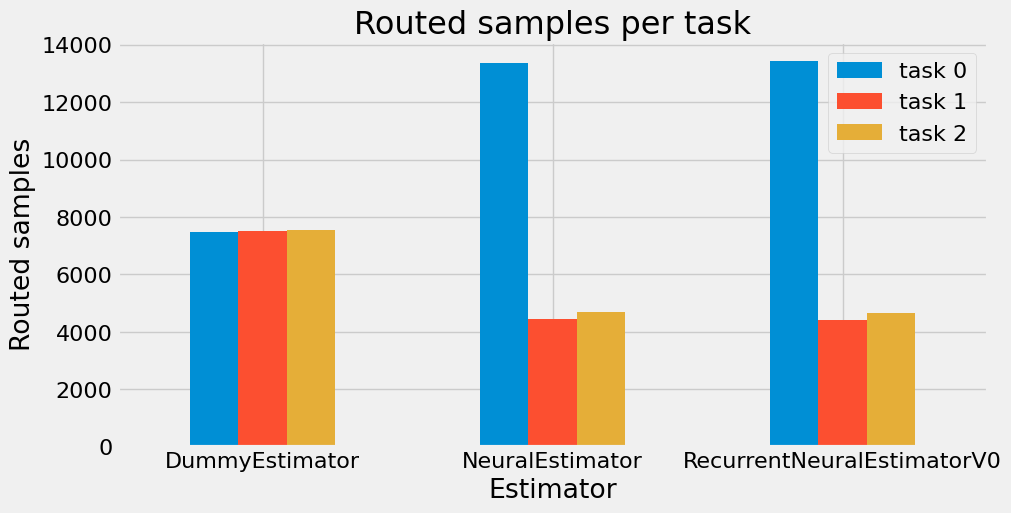

In [13]:
df = pd.DataFrame(columns=["estimator", "task 0", "task 1", "task 2"])
for i, (est_cls, routed_samples) in enumerate(estimator_routed_samples.items()):
    task_routed_samples = routed_samples.sum(axis=(1, 3)).mean(axis=0)
    print(task_routed_samples)
    df.loc[i] = [est_cls] + list(task_routed_samples)

# df plot where task 0, 1, 2 are the columns
df.plot.bar(x="estimator", rot=0, figsize=(10, 5))
plt.title("Routed samples per task")
plt.ylabel("Routed samples")
plt.xlabel("Estimator");


DummyEstimator task: 0 routed_samples: 10.624466571834994
NeuralEstimator task: 0 routed_samples: 19.0
RecurrentNeuralEstimatorV0 task: 0 routed_samples: 19.112375533428164
DummyEstimator task: 1 routed_samples: 10.658605974395448
NeuralEstimator task: 1 routed_samples: 6.337126600284495
RecurrentNeuralEstimatorV0 task: 1 routed_samples: 6.281650071123756
DummyEstimator task: 2 routed_samples: 10.716927453769559
NeuralEstimator task: 2 routed_samples: 6.662873399715505
RecurrentNeuralEstimatorV0 task: 2 routed_samples: 6.605974395448079


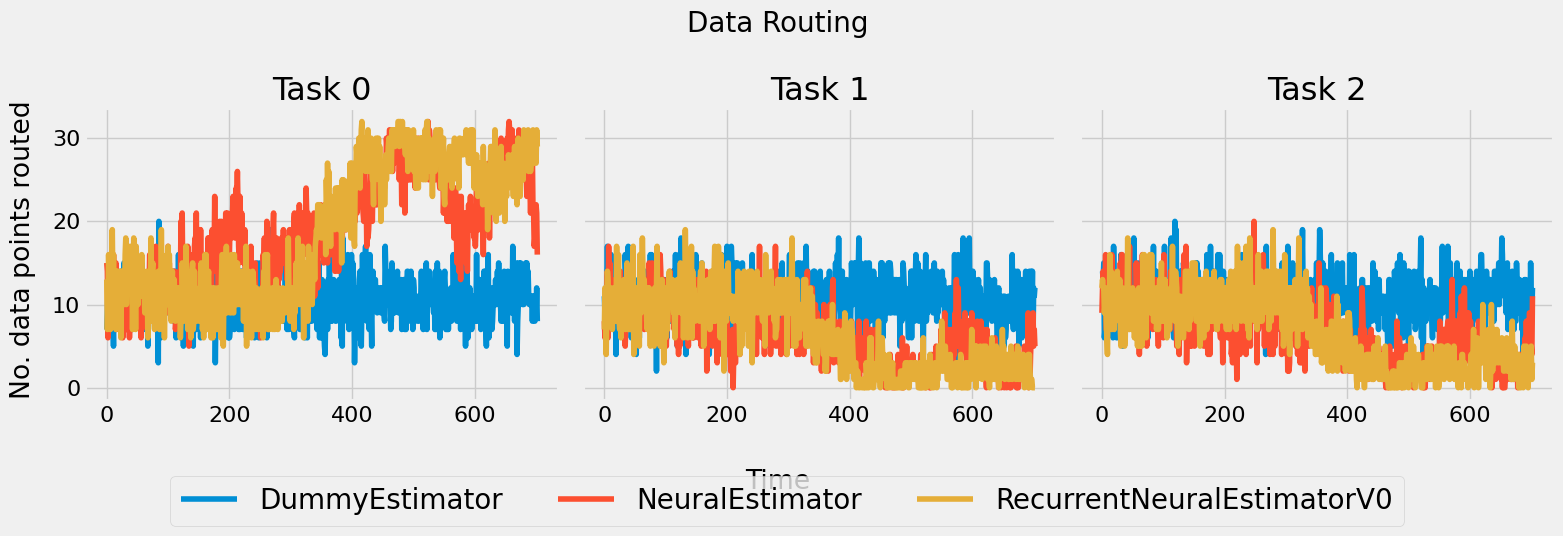

In [14]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(16, 5))

for task in range(3):
    for estimator_name, routed_samples in estimator_routed_samples.items():
        routed_samples_task = routed_samples.sum(axis=-1)[:, :, task]  # sum over classes
        ax[task].plot(routed_samples_task.mean(axis=0), label=estimator_name)
        std = routed_samples_task.std(axis=0)
        ax[task].fill_between(
            np.arange(len(std)),
            routed_samples_task.mean(axis=0) - std,
            routed_samples_task.mean(axis=0) + std,
            alpha=0.2,
        )
        ax[task].set_title(f"Task {task}")
        print(estimator_name, "task:", task, "routed_samples:", np.mean(routed_samples_task))

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=3, fontsize=20, bbox_to_anchor=(0.9, -0.08));
fig.suptitle("Data Routing", fontsize=20)
plt.rcParams.update({'font.size': 16})
fig.supxlabel("Time")
fig.supylabel("No. data points routed")
plt.tight_layout();

DummyEstimator -0.12734319254819562
NeuralEstimator -0.0015239947042288856
RecurrentNeuralEstimatorV0 -0.0002123159839961132


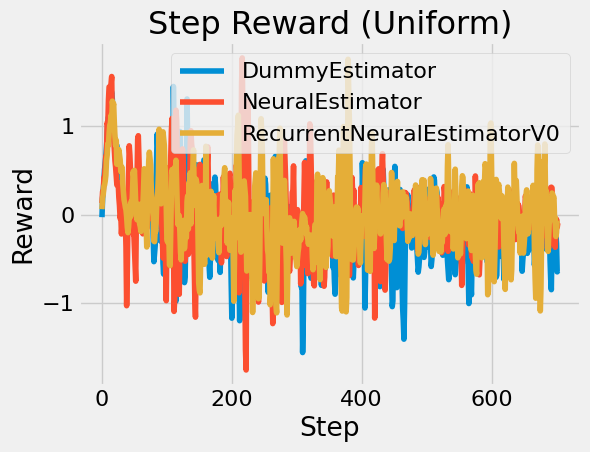

In [15]:
plt.title("Step Reward (Uniform)")
plt.ylabel("Reward")
plt.xlabel("Step")
for estimator_name, step_rewards in estimator_step_rewards.items():
    plt.plot(step_rewards.mean(axis=0), label=estimator_name)
    std = step_rewards.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        step_rewards.mean(axis=0) - std,
        step_rewards.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(step_rewards))
plt.legend(loc="best");
plt.tight_layout()

DummyEstimator 0.5738890477276238 0.7526999711990356
EmpiricalEstimator 0.7332968560036864 0.8863999843597412
NeuralEstimator 0.1619683197085661 0.1371999979019165
RecurrentNeuralEstimatorV0 0.17055056397326884 0.17669999599456787


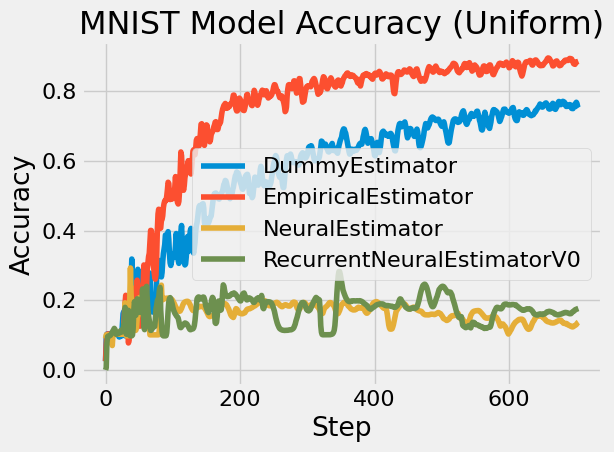

In [23]:
plt.title("MNIST Model Accuracy (Uniform)")
plt.ylabel("Accuracy")
plt.xlabel("Step")
for estimator_name, model_perfs in estimator_model_perfs.items():
    plt.plot(model_perfs.mean(axis=0), label=estimator_name)
    std = model_perfs.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        model_perfs.mean(axis=0) - std,
        model_perfs.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(model_perfs), model_perfs.mean(axis=0)[-1])
plt.legend(loc="best");
plt.tight_layout()

In [18]:
estimator_model_perfs_reduce8_image = estimator_model_perfs

In [10]:
# estimator_model_perfs_reduce2 = estimator_model_perfs

In [11]:
# estimator_model_perfs_reduce8 = estimator_model_perfs

In [12]:
# from matplotlib.pyplot import figure
# figure(figsize=(8, 6), dpi=80)

# plt.title("MNIST Model Accuracy (Uniform)")
# plt.ylabel("Accuracy")
# plt.xlabel("Step")

# reduce_2_colors = ["red", "darkred", "salmon"]
# reduce_8_colors = ["blue", "skyblue", "navy"]

# for estimator_name, model_perfs in estimator_model_perfs_reduce2.items():
#     plt.plot(model_perfs.mean(axis=0), label=estimator_name + " (50%)", color=reduce_2_colors.pop())
#     std = model_perfs.std(axis=0)
#     plt.fill_between(
#         np.arange(len(std)),
#         model_perfs.mean(axis=0) - std,
#         model_perfs.mean(axis=0) + std,
#         alpha=0.2,
#     )
#     print(estimator_name, np.mean(model_perfs), model_perfs.mean(axis=0)[-1])

# for estimator_name, model_perfs in estimator_model_perfs_reduce8.items():
#     plt.plot(model_perfs.mean(axis=0), label=estimator_name + " (12.5%)", linestyle='dotted', color=reduce_8_colors.pop())
#     std = model_perfs.std(axis=0)
#     plt.fill_between(
#         np.arange(len(std)),
#         model_perfs.mean(axis=0) - std,
#         model_perfs.mean(axis=0) + std,
#         alpha=0.2,
#     )
#     print(estimator_name, np.mean(model_perfs), model_perfs.mean(axis=0)[-1])
# plt.legend(loc="lower right");
# plt.tight_layout()

